# 第13章 计算机视觉 

## 13.1 图像增广

### 练习13.1.1

在不使用图像增广的情况下训练模型：`train_with_data_aug(no_aug, no_aug)`。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？

**解答：**

&emsp;&emsp;分别对采用图像增广和不采用图像增广的训练样本进行训练,并测试其分类精度。实验证明,使用水平翻转这一简单图像增广技术可以有效减轻过拟合问题。从实验test acc的曲线来看，不使用图像增广过拟合很明显，测试精度逐渐下降，而训练精度组件上升，而使用图像增广的结果都比较平稳，最后的分类精度也是更高的。
  
&emsp;&emsp;以下使用Pytorch编程，通过改变`train_with_data_aug(train_augs, test_augs, net)`的`train_augs`参数分别进行实验，其中`train_augs`采用了水平翻转这一图像增广方式,除此之外，还有垂直翻转，裁剪图像等增广方式，后续也会进行讨论。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import warnings
warnings.filterwarnings("ignore")

In [2]:
#下载数据
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
#图像增广的方法
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),#水平翻转
     # torchvision.transforms.RandomVerticalFlip(),#垂直翻转
     torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

Files already downloaded and verified


In [3]:
#辅助函数：此函数在输入图像上多次运行图像增广方法并显示所有结果
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)
    
#辅助函数：读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [4]:
#训练函数
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [5]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

#初始化权重
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)


#使用图像增广来训练模型
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.076, train acc 0.973, test acc 0.786
4495.0 examples/sec on [device(type='cuda', index=0)]


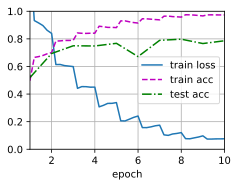

In [6]:
#不使用图像增广
net.apply(init_weights)
train_with_data_aug(test_augs, test_augs, net)

loss 0.194, train acc 0.933, test acc 0.833
4689.0 examples/sec on [device(type='cuda', index=0)]


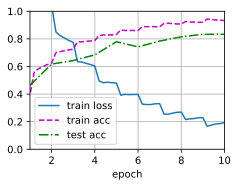

In [7]:
#使用图像增广
net.apply(init_weights)
train_with_data_aug(train_augs, test_augs, net)

### 练习13.1.2

在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？

**解答：**

&emsp;&emsp;基于CIFAR-10数据集,在模型训练过程中使用不同的图像增强方法,可以明显提升测试精度。通过加入噪声或者图像翻转等操作来对训练集数据进行增强,可以帮助模型学习到更加鲁棒和泛化的特征。这是因为采用了数据增强后,模型在训练过程中学习到的知识会更易于应用于测试集的数据上。特别是对于那些自然场景下没有噪声的测试图像,预处理中加入相应的噪声会使模型更易于识别这类图像。

loss 0.457, train acc 0.839, test acc 0.811
4688.3 examples/sec on [device(type='cuda', index=0)]


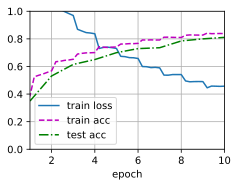

In [8]:
# 使用Compose串联多个数据增强
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),   # 随机旋转，-10到10度之间随机选
    torchvision.transforms.RandomHorizontalFlip(p=0.5),         # 随机水平翻转 选择一个概率概率
    torchvision.transforms.RandomVerticalFlip(p=0.5),           # 随机垂直翻转
    torchvision.transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
])

net.apply(init_weights)
train_with_data_aug(augs, test_augs, net)

### 练习13.1.3

参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？

**解答：**

&emsp;&emsp;以下是一些常见的图像增广方法，包括裁剪、翻转和旋转、以及图像变换等。在PyTorch中，你可以使用transforms模块来轻松实现这些操作。

- **裁剪（Crop）**
    - 中心裁剪：`transforms.CenterCrop` 
    - 随机裁剪：`transforms.RandomCrop` 
    - 随机长宽比裁剪：`transforms.RandomResizedCrop` 
    - 上下左右中心裁剪：`transforms.FiveCrop` 
    - 上下左右中心裁剪后翻转（默认水平翻转）：`transforms.TenCrop`

- **翻转和旋转（Flip and Rotation）**
    - 依概率p（默认p=0.5）水平翻转：`transforms.RandomHorizontalFlip`
    - 依概率p（默认p=0.5）垂直翻转：`transforms.RandomVerticalFlip`
    - 随机旋转：`transforms.RandomRotation`

- **图像变换（Resize）**
    - 标准化：`transforms.Normalize` 
    - 转为tensor，并归一化至[0-1]：`transforms.ToTensor` 
    - 填充：`transforms.Pad` 
    - 修改亮度、对比度和饱和度：`transforms.ColorJitter` 
    - 转灰度图：`transforms.Grayscale` 
    - 线性变换：`transforms.LinearTransformation`
    - 仿射变换：`transforms.RandomAffine` 
    - 依概率p转为灰度图：`transforms.RandomGrayscale` 
    - 将数据转换为PILImage：`transforms.ToPILImage`

此外，在PyTorch的高版本中，torchvision.transforms分为v1和v2版本，为分类任务提供了一些高级的数据增广方法，如MixUp和CutMix。

- **Cutout**
    - 随机在图像中剪切一块区域，防止网络过度依赖特定位置的信息：`transforms.v2.CutMix(num_classes=NUM_CLASSES)`

- **Mixup**
    - 将两张图像按照一定的权重混合在一起，生成新的训练样本：`transforms.v2.MixUp(num_classes=NUM_CLASSES)`

更详细的内容请参考以下资料：


1. [PyTorch官方文档](https://pytorch.org/vision/stable/transforms.html#auto-augmentation)：查阅官方文档以获取有关PyTorch图像增广的详细信息和自动增强的方法。

2. [imgaug库（提供了多种图片增强的方法并进行了可视化）](https://github.com/aleju/imgaug#documentation)：探索imgaug库，它提供了多种图像增强方法，并通过可视化方式进行展示。

3. [数据增强应用](https://zhuanlan.zhihu.com/p/398245376)：了解数据增强的应用场景和方法，以便更好地优化模型训练数据。

4. [CutMix 和 MixUp使用方法](https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html)：了解如何使用CutMix和MixUp这两种高级数据增强方法，以提升分类任务的性能。

## 13.2 微调

### 练习13.2.1

继续提高`finetune_net`的学习率，模型的准确性如何变化？

**解答：**

&emsp;&emsp;将`finetune_net`模型的学习率分别设为$5\times10^{-5}$、$5\times10^{-4}$和$5\times10^{-3}$。通过对比发现，当模型的学习率较大时，可能会导致训练过程中的震荡或发散，使得模型无法收敛或者收敛到不理想的解决方案。而当模型的学习率较小时，在实验中表现出最优的效果，迅速实现了收敛，并获得了最优的精度。

&emsp;&emsp;若深入思考这一结果的原因，我们已经采用了在ImageNet预训练的resnet18，因此模型已经具备一定的知识。在进行优化训练时，由于学习率不需要过大，模型能够迅速将知识迁移到我们的数据集中。较大的学习率可能导致跳出最优值附近，导致震荡波动的结果。然而，在一些任务和问题中，需要在学习率上进行权衡，因为较大的学习率能够实现更快速的收敛，尽管不够稳定；而较小的学习率则更为稳定，尽管需要更长的时间。因此，选择适当的学习率对于任务的成功至关重要。

In [9]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [10]:
#获取并读取数据集
if os.path.exists('../data/hotdog'):
    data_dir = '../data/hotdog'
else:
    # 自动下载数据集
    d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
    data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

In [11]:
# 创建一个用于将图像标准化的Transform
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# 创建训练集图像增强的Transform
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # 随机裁剪为224x224大小
    torchvision.transforms.RandomHorizontalFlip(),  # 随机水平翻转
    torchvision.transforms.ToTensor(),  # 将图像转换为Tensor
    normalize  # 标准化图像
])

# 创建测试集图像增强的Transform
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),  # 将图像的短边缩放到256像素
    torchvision.transforms.CenterCrop(224),  # 从中心裁剪224x224大小
    torchvision.transforms.ToTensor(),  # 将图像转换为Tensor
    normalize  # 标准化图像
])

In [12]:
# 定义初始模型并微调
pretrained_net = torchvision.models.resnet18(pretrained=True)
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    """
    对模型进行微调训练

    参数:
        net: 待训练的模型
        learning_rate: 学习率
        batch_size: 批大小，默认为128
        num_epochs: 训练轮数，默认为5
        param_group: 是否对输出层中的模型参数使用十倍的学习率，默认为True
    """
    # 加载训练集和测试集数据
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group: # 如果 `param_group=True`，输出层中的模型参数将使用十倍的学习率
        # 获取除输出层以外的模型参数
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        # 使用不同的学习率对参数进行优化
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        # 使用相同学习率对所有参数进行优化
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    # 进行训练
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.292, train acc 0.902, test acc 0.938
1172.8 examples/sec on [device(type='cuda', index=0)]


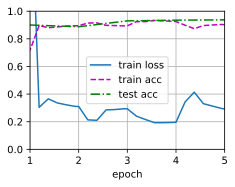

In [13]:
# 使用学习率5e-5进行微调训练
finetune_net = torchvision.models.resnet18(pretrained=True)  # 加载预训练的ResNet-18模型
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)  # 替换输出层为二类分类器
nn.init.xavier_uniform_(finetune_net.fc.weight)  # 初始化输出层权重（使用Xavier均匀初始化）

train_fine_tuning(finetune_net, 5e-5)  # 调用train_fine_tuning函数进行微调训练，使用学习率5e-5

loss 0.448, train acc 0.809, test acc 0.766
1195.1 examples/sec on [device(type='cuda', index=0)]


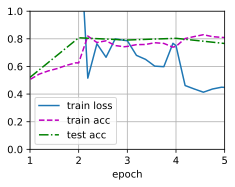

In [14]:
# 使用学习率5e-4进行微调训练
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

train_fine_tuning(finetune_net, 5e-4)

loss 0.985, train acc 0.596, test acc 0.677
1192.2 examples/sec on [device(type='cuda', index=0)]


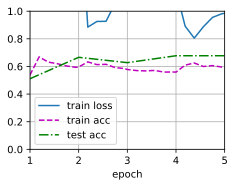

In [15]:
# 使用学习率5e-3进行微调训练
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

train_fine_tuning(finetune_net, 5e-3)

### 练习13.2.2

在比较实验中进一步调整`finetune_net`和`scratch_net`的超参数。它们的准确性还有不同吗？

**解答：**

&emsp;&emsp;在比较实验中，我们进一步调整了`finetune_net`和`scratch_net`的超参数。尤其是，我们专注于探究`param_group`参数的影响，该参数将输出层（即FC层）的学习率设置为原先的10倍，而其它层的学习率保持不变，并且只微调输出层部分。

&emsp;&emsp;在其他超参数相同的情况下，分别将`finetune_net`模型或`scratch_net`模型的超参数`param_group`设置为True，结果表明模型在训练集和测试集上的精度均出现下降。

&emsp;&emsp;从最后的结果来看，在实验中，使用预训练模型+微调线性层能得到更好的效果，在线性层中可以使用更大的学习率。

loss 0.184, train acc 0.929, test acc 0.924
1182.8 examples/sec on [device(type='cuda', index=0)]


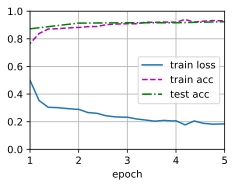

In [16]:
#微调所有层：原先的 param_group=False
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

train_fine_tuning(finetune_net, 5e-5, param_group=False)

loss 0.186, train acc 0.930, test acc 0.944
1187.4 examples/sec on [device(type='cuda', index=0)]


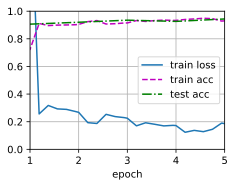

In [17]:
#微调分类层：param_group设置为True
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

train_fine_tuning(finetune_net, 5e-5, param_group=True)

loss 0.527, train acc 0.803, test acc 0.816
1194.5 examples/sec on [device(type='cuda', index=0)]


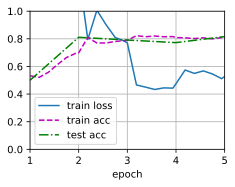

In [18]:
#微调全部层，无预训练模型：原先的
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4)

loss 0.415, train acc 0.818, test acc 0.801
1191.3 examples/sec on [device(type='cuda', index=0)]


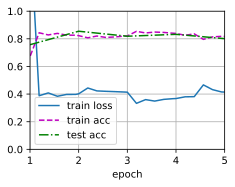

In [19]:
#微调全部层，无预训练模型：param_group=False
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

### 练习13.2.3

将输出层`finetune_net`之前的参数设置为源模型的参数，在训练期间不要更新它们。模型的准确性如何变化？提示：可以使用以下代码。

```python
for param in finetune_net.parameters():
    param.requires_grad = False
```

**解答：**


&emsp;&emsp;这段代码的目的是将`finetune_net`模型的输出层之前的所有参数的`requires_grad`属性设置为`False`，从而冻结这些参数，使其在训练期间不会被更新。这样的操作通常用于迁移学习中，以保持源模型已经学到的知识，同时允许新模型专注于学习目标任务的特定特征。

解释如下：

1. **`finetune_net`模型的参数遍历：** 通过`for param in finetune_net.parameters():`这行代码，对`finetune_net`模型中的所有参数进行迭代。

2. **`param.requires_grad = False`：** 对每个参数，将其`requires_grad`属性设置为`False`。这意味着这些参数在反向传播过程中不会计算梯度，也就是说它们的值在训练过程中将保持不变。


&emsp;&emsp;提示代码可以将`finetune_net`模型中输出层之前的所有参数的`requires_grad`属性设置为`False`，从而禁用它们的梯度计算和更新。这意味着在训练过程中，这些参数将保持不变，这样可以更好地保留源模型的知识，同时允许新模型专注于学习目标任务的特定特征。在实践中，通过参数冻结，可以在新任务上更有效地利用源模型的知识，提高模型在新任务上的性能。

In [20]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    """
    对模型进行微调训练，加入了冻结参数部分

    参数:
        net: 待训练的模型
        learning_rate: 学习率
        batch_size: 批大小，默认为128
        num_epochs: 训练轮数，默认为5
        param_group: 是否对输出层中的模型参数使用十倍的学习率，默认为True
    """
    # 加载训练集和测试集数据
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()  # 尝试使用所有可用的GPU设备
    loss = nn.CrossEntropyLoss(reduction="none")  # 定义交叉熵损失函数
    if param_group:
        params_lx = []
        # 除分类层之外都不更新参数
        for name, param in net.named_parameters():
            if name not in ["fc.weight", "fc.bias"]:
                params_lx.append(param)
                param.requires_grad = False  # 不更新参数
        # 使用不同的学习率对参数进行优化
        trainer = torch.optim.SGD([{'params': params_lx},
                                   {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        # 使用相同学习率对所有参数进行优化
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    # 进行训练
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.523, train acc 0.846, test acc 0.914
2605.7 examples/sec on [device(type='cuda', index=0)]


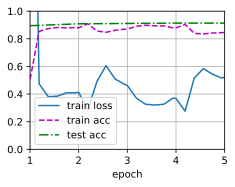

In [21]:
# 微调分类层，利用新的train_fine_tuning只微调分类层

# 创建一个预训练的ResNet-18模型
finetune_net = torchvision.models.resnet18(pretrained=True)

# 将模型的输出层替换为一个包含2个输出类别的全连接层
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)

# 使用Xavier均匀初始化方法对输出层的权重进行初始化
nn.init.xavier_uniform_(finetune_net.fc.weight)

# 调用train_fine_tuning函数进行微调训练，传入微调后的模型和学习率5e-5作为参数
train_fine_tuning(finetune_net, 5e-5)

### 练习13.2.4

事实上，`ImageNet`数据集中有一个“热狗”类别。我们可以通过以下代码获取其输出层中的相应权重参数，但是我们怎样才能利用这个权重参数？

```python
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape
```

**解答：**

&emsp;&emsp;由题目可知`hotdog_w`是`resnet18`模型的输出层中预测类别为“热狗”的权重参数，`finetune_net`模型输出层中预测类别为“热狗”的权重参数可以复用`hotdog_w`，具体代码如下：

loss 0.435, train acc 0.870, test acc 0.904
2622.4 examples/sec on [device(type='cuda', index=0)]


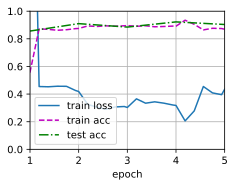

In [22]:
# 创建一个预训练的ResNet-18模型
finetune_net = torchvision.models.resnet18(pretrained=True)

# 获取预训练模型“热狗”类别输出层的参数
weight = finetune_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]

# 将模型的输出层替换为一个包含2个输出类别的全连接层
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)

# 使用Xavier均匀初始化方法对输出层的权重进行初始化
nn.init.xavier_uniform_(finetune_net.fc.weight)

# 将预训练模型“热狗”类别的输出层参数复制到微调后的模型的第一行
finetune_net.fc.weight.data[0] = hotdog_w.data.reshape(-1)

# 调用train_fine_tuning函数进行微调训练，传入微调后的模型和学习率5e-5作为参数
train_fine_tuning(finetune_net, 5e-5)

## 13.3 目标检测和边界框

### 练习13.3.1

找到另一张图像，然后尝试标记包含该对象的边界框。比较标注边界框和标注类别哪个需要更长的时间？

**解答：**

&emsp;&emsp;标注边界框需要更长的时间,因为需要标注边界框以后再标注类别，而且类别是比较容易看的出来的。下面给出标记另一图像边界框的代码：

In [23]:
import torch
from d2l import torch as d2l
d2l.set_figsize()
img = d2l.plt.imread('../img/cat2.jpg')
cat_bbox= [552.0, 335.0, 848.0, 1076.0]
boxes = torch.tensor([cat_bbox])#增加一个维度，批量大小为1
d2l.box_center_to_corner(d2l.box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True]])

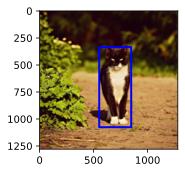

In [24]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(d2l.bbox_to_rect(cat_bbox, 'blue'))

### 练习13.3.2

为什么`box_corner_to_center`和`box_center_to_corner`的输入参数的最内层维度总是4？

**解答：**

&emsp;&emsp;`box_corner_to_center`和`box_center_to_corner`是在目标检测中广泛使用的边界框坐标转换函数，用于在不同边界框表示形式之间进行转换。这两个函数的输入参数的最内层维度总是4，原因在于通常所采用的边界框表示形式是基于矩形框的四个角点或中心点来定义的。

&emsp;&emsp;具体而言，这里的4代表了一个矩形框的四个坐标或尺寸信息，按照以下顺序排列：

- 对于`box_corner_to_center`函数，输入的边界框表示形式是基于四个角点（左上、右上、右下、左下）的坐标来定义的。因此，输入参数的最内层维度为[左上x，左上y，右下x，右下y]，其中x和y表示坐标轴的位置。

- 对于`box_center_to_corner`函数，输入的边界框表示形式是基于中心点坐标和边界框的宽度和高度来定义的。因此，输入参数的最内层维度为[中心点x，中心点y，宽度，高度]，其中x和y表示中心点的位置。

&emsp;&emsp;在具体的实现中，应该根据所使用的边界框表示形式来确定输入参数的维度和顺序。

## 13.4 锚框

### 练习13.4.1

在`multibox_prior`函数中更改`sizes`和`ratios`的值。生成的锚框有什么变化？

**解答：**

&emsp;&emsp;假设输入图像的高度为$h$，宽度为$w$。
我们以图像的每个像素为中心生成不同形状的锚框：*比例*为$s\in (0, 1]$，*宽高比*（宽高比）为$r > 0$。
那么**锚框的宽度和高度分别是$ws\sqrt{r}$和$hs/\sqrt{r}$。**

&emsp;&emsp;`multibox_prior`函数是目标检测中用于生成锚框（anchor boxes）的常用函数之一。通过更改`sizes`和`ratios`的值，可以影响生成的锚框的尺寸$s$和宽高比$r$。

- `sizes`参数控制生成的锚框的尺寸。它是一个包含多个正数的列表或数组，每个正数表示一个锚框的尺寸。更改`sizes`的值将导致生成的锚框在尺寸上发生变化。较大的尺寸值将生成更大的锚框，而较小的尺寸值将生成更小的锚框。

- `ratios`参数控制生成的锚框的宽高比。它是一个包含多个正数的列表或数组，每个正数表示一个锚框的宽高比。更改`ratios`的值将影响生成的锚框在宽高比上的分布。较高的比率值将生成更窄的锚框，而较低的比率值将生成更宽的锚框。

&emsp;&emsp;生成的锚框通常以一组默认的锚点（anchor points）为中心进行平移和缩放。这些默认的锚点通常是在图像网格中均匀分布的固定点。通过调整`sizes`和`ratios`，可以控制生成的锚框在不同尺度和宽高比上的分布，以适应不同大小和形状的目标。

### 练习13.4.2

构建并可视化两个IoU为0.5的边界框。它们是怎样重叠的？

**解答：**

&emsp;&emsp;接下来实现对应的代码，包括可视化的代码，以及IoU部分

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")
def plot_boxes(boxes1, boxes2):
    """
    绘制两个边界框的函数

    参数:
        boxes1: 第一个边界框的坐标列表，每个边界框由四个坐标值组成
        boxes2: 第二个边界框的坐标列表，每个边界框由四个坐标值组成
    """
    fig, ax = plt.subplots()
    # 绘制第一个边界框
    for box in boxes1:
        rect1 = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='r', alpha=0.5)
        ax.add_patch(rect1)
    
    # 绘制第二个边界框
    for box in boxes2:
        rect2 = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='b', alpha=0.5)
        ax.add_patch(rect2)


    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)

    ax.set_xticks([0, 2, 4, 6])
    ax.set_yticks([0, 2, 4, 6])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    plt.show()
    
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比。"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # `boxes1`, `boxes2`, `areas1`, `areas2`的形状:
    # `boxes1`：(boxes1的数量, 4),
    # `boxes2`：(boxes2的数量, 4),
    # `areas1`：(boxes1的数量,),
    # `areas2`：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    #  `inter_upperlefts`, `inter_lowerrights`, `inters`的形状:
    # (boxes1的数量, boxes2的数量, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # `inter_areas` and `union_areas`的形状: (boxes1的数量, boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

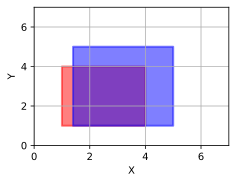

0.4999999701976776


In [26]:
# 定义两个边界框列表并绘图
boxes1 = torch.tensor([[1,1,4,4]])
boxes2 = torch.tensor([[1.4,1,5,5]])
plot_boxes(boxes1, boxes2)
# 计算IoU
iou = box_iou(boxes1, boxes2)
print(iou.item())

### 练习13.4.3

在13.4.3节和13.4.4节中修改变量`anchors`，结果如何变化？

**解答：**

&emsp;&emsp;针对13.4.3节所用的算法，我们修改`anchors`的值，结果如下：

In [27]:
%matplotlib inline
import torch
from d2l import torch as d2l
torch.set_printoptions(2)  # 设置打印精度

# 读取图像并获取图像的高度和宽度
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]

# 生成输入数据X，维度为(1, 3, h, w)
X = torch.rand(size=(1, 3, h, w))

# 使用d2l.multibox_prior函数生成多个锚框
# 参数sizes指定锚框的尺寸，ratios指定锚框的长宽比
Y = d2l.multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
# 锚框的形状为(h, w, 5, 4)，其中h和w是图像的高度和宽度

# 将锚框重新形状为(h, w, 5, 4)
boxes = Y.reshape(h, w, 5, 4)

# 设置图形的大小
d2l.set_figsize()

# 创建一个tensor，用于恢复原始坐标值
bbox_scale = torch.tensor((w, h, w, h))

tensor([[0, 1, 2, 0, 2]])


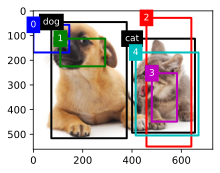

In [28]:
#使用原始anchor参数的结果
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
d2l.show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
d2l.show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);
labels = d2l.multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))#根据狗和猫的真实边界框，标注这些锚框的分类和偏移量
print(labels[2])#第三个元素包含标记的输入锚框的类别，背景、狗和猫的类索引分别为0、1和2

tensor([[0, 1, 2, 0, 2]])


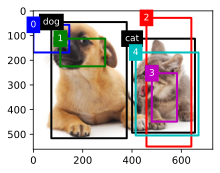

In [29]:
# 使用原始anchor参数的结果
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])

anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

# 显示原始图像
fig = d2l.plt.imshow(img)

# 显示真实边界框
d2l.show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')

# 显示锚框
d2l.show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

# 标注锚框的分类和偏移量
labels = d2l.multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))
# labels是一个长度为4的元组，其中第三个元素包含标记的输入锚框的类别，
# 背景、狗和猫的类索引分别为0、1和2
print(labels[2])

&emsp;&emsp;针对13.4.4节所用的算法，我们修改`anchors`的值，结果如下：

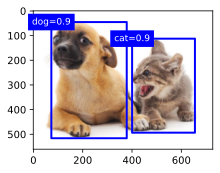

In [30]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])

offset_preds = torch.tensor([0] * anchors.numel())

cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

# 使用d2l.multibox_detection函数进行预测
output = d2l.multibox_detection(cls_probs.unsqueeze(dim=0),
                                offset_preds.unsqueeze(dim=0),
                                anchors.unsqueeze(dim=0),
                                nms_threshold=0.5)

# 显示图像
fig = d2l.plt.imshow(img)

# 遍历预测结果并显示边界框
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    # 根据预测结果的类别，选择标签
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    # 显示边界框
    d2l.show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

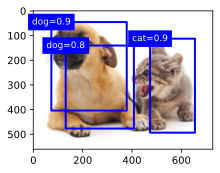

In [31]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.72], [0.18, 0.25, 0.56, 0.85],
                        [0.15, 0.3, 0.62, 0.91], [0.65, 0.2, 0.9, 0.88]])

offset_preds = torch.tensor([0] * anchors.numel())

cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

# 使用d2l.multibox_detection函数进行预测
output = d2l.multibox_detection(cls_probs.unsqueeze(dim=0),
                                offset_preds.unsqueeze(dim=0),
                                anchors.unsqueeze(dim=0),
                                nms_threshold=0.5)

# 显示图像
fig = d2l.plt.imshow(img)

# 遍历预测结果并显示边界框
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    # 根据预测结果的类别，选择标签
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    # 显示边界框
    d2l.show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

### 练习13.4.4                
                
非极大值抑制是一种贪心算法，它通过*移除*来抑制预测的边界框。是否存在一种可能，被移除的一些框实际上是有用的？如何修改这个算法来柔和地抑制？可以参考Soft-NMS。

**解答：**

&emsp;&emsp;非极大值抑制（Non-Maximum Suppression，NMS），它是一种常用于目标检测中的后处理技术，用于去除冗余的边界框。NMS的目标是选择具有最高置信度的边界框，并消除与其高度重叠的其他边界框。但确实存在一种情况，即一些被移除的边界框实际上可能是有用的。例如，在目标密集的场景中，一些预测可能被错误地视为冗余，但实际上代表了不同的目标实例。这可能导致漏检（missed detections）问题。

&emsp;&emsp;为了解决这个问题，提出了一种叫做Soft-NMS的改进版本。Soft-NMS旨在通过减小与高置信度边界框重叠的其他边界框的置信度来柔和地抑制它们，而不是完全移除它们。这样可以保留一些被抑制的边界框，以更好地捕捉目标检测中的细微变化。

&emsp;&emsp;Soft-NMS的主要思想是通过引入一个衰减函数，降低与高置信度边界框重叠的其他边界框的置信度。这样，即使边界框之间存在一定的重叠，仍然有机会保留一些低置信度的边界框。

&emsp;&emsp;在Soft-NMS中，算法的步骤如下：
1. 对所有的边界框按照置信度进行排序，选取置信度最高的边界框作为当前最佳边界框。
2. 对于与当前最佳边界框重叠超过一定阈值的其他边界框，使用衰减函数降低它们的置信度。
3. 重复步骤1和2，直到所有的边界框被处理完毕或达到停止条件。

&emsp;&emsp;通过**引入衰减函数**，Soft-NMS能够在一定程度上保留一些被抑制的边界框，从而提高对密集目标的检测能力。

### 练习13.4.5
        
如果非手动，非最大限度的抑制可以被学习吗？

**解答：**

&emsp;&emsp;非手动和非最大值抑制（Non-Maximum Suppression，NMS）可以通过机器学习方法进行学习。传统的NMS是一种手动设计的算法，它使用固定的阈值和规则来抑制冗余的边界框。一种常见的方法是将非最大值抑制作为一个模块嵌入到目标检测网络中，并与目标检测任务一起进行训练。这样，网络可以学习如何根据置信度、重叠度等因素来选择保留或抑制边界框。

&emsp;&emsp;可以使用以下方法之一来实现学习非最大值抑制：

1. End-to-End方法：将非最大值抑制集成到整个目标检测网络的训练过程中。在网络的输出中，除了目标类别和边界框的预测之外，还可以增加一个分支用于预测每个边界框的抑制得分。这样，网络可以通过端到端的训练来学习如何进行抑制，使得保留的边界框更加准确。

2. Two-Stage方法：这种方法包括两个阶段，首先进行候选框生成，然后应用非最大值抑制来筛选候选框。在第一个阶段，通过一个候选框生成网络生成大量的候选框。然后，在第二个阶段，通过训练一个辅助网络来学习非最大值抑制的策略，从候选框中选择最佳的边界框。

&emsp;&emsp;这些方法将非最大值抑制问题形式化为一个可以通过反向传播进行优化的学习任务。通过在目标检测网络中嵌入非最大值抑制的学习，可以根据具体任务和数据集的特点来自适应地选择保留或抑制边界框，从而提高目标检测的性能。学习非最大值抑制的方法需要足够的训练数据和计算资源，并且可能需要进行一定的调试和优化来获得最佳的结果。

## 13.5 多尺度目标检测

### 练习13.5.1

根据我们在7.1节中的讨论，深度神经网络学习图像特征级别抽象层次，随网络深度的增加而升级。在多尺度目标检测中，不同尺度的特征映射是否对应于不同的抽象层次？为什么？

**解答：**

&emsp;&emsp;在多尺度目标检测中，不同尺度的特征映射通常对应于不同的抽象层次。这是由于不同尺度的特征提取器在网络中的位置不同，而网络的层数会直接影响到特征提取器的感受野大小。

&emsp;&emsp;浅层的特征提取器通常具有较小的感受野，能够提取图像的低级特征，比如边缘、纹理等。而随着网络深度的增加，特征提取器的感受野逐渐扩大，能够涵盖更大范围的图像结构和语义信息，从而提取更高级的特征，如物体的形状、部件等。

&emsp;&emsp;因此，在多尺度目标检测中，较浅层的特征映射通常对应于较低级的抽象层次，而较深层的特征映射对应于较高级的抽象层次。这种多尺度的特征映射组合可以有效捕捉目标在不同尺度上的表征和上下文信息，从而显著提高目标检测的性能。这种层次化的特征学习是深度神经网络在图像处理任务中取得成功的关键因素之一。

### 练习13.5.2

在13.5.1节中的实验里的第一个尺度（`fmap_w=4, fmap_h=4`）下，生成可能重叠的均匀分布的锚框。

**解答：**

&emsp;&emsp;这一部分我们可以通过调整`display_anchors`中的`s`参数实现，设置为0.25，均匀分布：

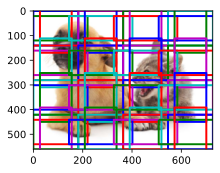

In [32]:
%matplotlib inline
import torch
from d2l import torch as d2l

def display_anchors(fmap_w, fmap_h, s):
    """
    显示锚框

    参数：
        fmap_w：特征图的宽度
        fmap_h：特征图的高度
        s：锚框的尺度

    返回：
        无
    """
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

# 读取图像
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
# 显示锚框
display_anchors(fmap_w=4, fmap_h=4, s=[0.25])

### 练习13.5.3

给定形状为$1 \times c \times h \times w$的特征图变量，其中$c$、$h$和$w$分别是特征图的通道数、高度和宽度。怎样才能将这个变量转换为锚框类别和偏移量？输出的形状是什么？

**解答：**

&emsp;&emsp;设每个像素生成$a$个锚框。目标类别的数量为$q$，则锚框类别数量为$q+1$，其中第0类是背景。每个锚框对应四个偏移量。

&emsp;&emsp;锚框类别：首先通过卷积将特征图通道数变为$a \times  (q+1)$，后续输出维度的变换过程如下：
$$(1,a \times  (q+1),h,w)\longrightarrow(1,h\times w \times a \times  (q+1)) \longrightarrow (1,h \times w \times a,q+1)$$

&emsp;&emsp;偏移量：首先通过卷积将特征图通道数变为$4×a$，后续输出维度的变换过程如下：
$$(1,4 \times a,h,w)\longrightarrow(1,h\times w \times a)$$

In [33]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

def cls_predictor(num_inputs, num_anchors, num_classes):
    """
    创建分类预测器模块

    参数：
        num_inputs：输入通道数
        num_anchors：锚框数量
        num_classes：类别数量

    返回：
        nn.Conv2d模块
    """
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=1)

def bbox_predictor(num_inputs, num_anchors):
    """
    创建边界框预测器模块

    参数：
        num_inputs：输入通道数
        num_anchors：锚框数量

    返回：
        nn.Conv2d模块
    """
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=1)

def forward(x, block):
    """
    前向传播函数

    参数：
        x：输入张量
        block：模块

    返回：
        模块的输出张量
    """
    return block(x)

def flatten_pred(pred):
    """
    将预测张量展平

    参数：
        pred：预测张量

    返回：
        展平后的预测张量
    """
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

# 创建一个输入张量
X = torch.zeros((1, 8, 20, 20))
num_classes = 10
sizes = [0.2, 0.272, 0.37]
ratios = [1, 2, 0.5]
num_anchors = len(sizes) + len(ratios) - 1

# 创建分类预测器并进行前向传播
cls_preds = forward(X, cls_predictor(8, num_anchors, num_classes))
print(cls_preds.shape)

# 创建边界框预测器并进行前向传播
bbox_preds = forward(X, bbox_predictor(8, num_anchors))
print(bbox_preds.shape)

# 展平分类预测张量和边界框预测张量
cls_preds = flatten_pred(cls_preds)
cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, num_classes + 1)
bbox_preds = flatten_pred(bbox_preds)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([1, 55, 20, 20])
torch.Size([1, 20, 20, 20])
torch.Size([1, 2000, 11])
torch.Size([1, 8000])


## 13.6 目标检测数据集

### 练习13.6.1

在香蕉检测数据集中演示其他带有真实边界框的图像。它们在边界框和目标方面有什么不同？

**解答：**

&emsp;&emsp;边界框的宽高比、缩放比和位置有所不同；目标图像中香蕉的旋转角度、大小和位置、光照等都有所不同。

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


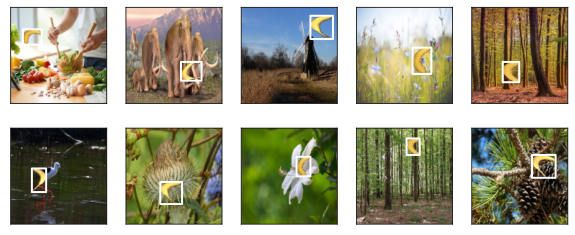

In [34]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 设置批量大小和图像边长
batch_size, edge_size = 32, 256
# 加载香蕉数据集的训练集
train_iter, _ = d2l.load_data_bananas(batch_size)
# 获取一个批量的数据
batch = next(iter(train_iter))
# 打印输入图像张量和标签张量的形状
print(batch[0].shape, batch[1].shape)

# 取出部分图像作为示例，并调整通道维度和像素值范围
imgs = (batch[0][11:21].permute(0, 2, 3, 1)) / 255
# 显示示例图像并绘制真实边界框
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][11:21]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

### 练习13.6.2

假设我们想要将数据增强（例如随机裁剪）应用于目标检测。它与图像分类中的有什么不同？提示：如果裁剪的图像只包含物体的一小部分会怎样？

**解答：**

&emsp;&emsp;当将数据增强技术应用于目标检测任务时，与图像分类任务相比，存在一些重要的区别。

- **目标完整性：** 在目标检测中，物体的完整性对于正确的目标定位和识别至关重要。如果随机裁剪的图像只包含物体的一小部分，可能会导致目标部分遗漏或缺失。这对目标检测算法的性能会产生负面影响，因为算法可能无法准确地定位和识别不完整的目标。

- **边界框更新：** 在图像分类中，数据增强通常只需要在图像上应用相同的变换，而不会修改类别标签。然而，在目标检测中，当应用裁剪等数据增强操作时，需要相应地更新目标的边界框。裁剪操作会改变目标在图像中的位置和大小，因此需要更新目标的边界框坐标以准确地反映裁剪后的图像。

- **多对象处理：** 目标检测通常涉及同时检测和识别图像中的多个对象。因此，在数据增强过程中，需要确保所有目标的完整性和可见性。随机裁剪等操作应考虑到所有目标的位置和大小，以确保不会遮挡或分割目标。

在目标检测中，细致处理数据增强是至关重要的，以确保训练模型能够有效地应对多个尺度、多个目标和目标的变化条件。

## 13.7 单发多框检测（SSD）

### 练习13.7.1

能通过改进损失函数来改进单发多框检测吗？例如，将预测偏移量用到的$L_1$范数损失替换为平滑$L_1$范数损失。它在零点附近使用平方函数从而更加平滑，这是通过一个超参数$\sigma$来控制平滑区域的：

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

当$\sigma$非常大时，这种损失类似于$L_1$范数损失。当它的值较小时，损失函数较平滑。

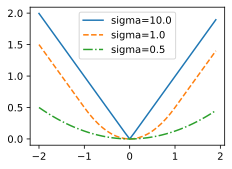

In [35]:
def smooth_l1(data, scalar):
    """
    平滑L1损失函数

    参数：
        data：输入数据
        scalar：缩放因子

    返回：
        平滑L1损失
    """
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

# 定义一些参数
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

# 绘制平滑L1损失函数曲线
for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

此外，在类别预测时，实验中使用了交叉熵损失：设真实类别$j$的预测概率是$p_j$，交叉熵损失为$-\log p_j$。我们还可以使用焦点损失。给定超参数$\gamma > 0$和$\alpha > 0$，此损失的定义为：

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

可以看到，增大$\gamma$可以有效地减少正类预测概率较大时（例如$p_j > 0.5$）的相对损失，因此训练可以更集中在那些错误分类的困难示例上。

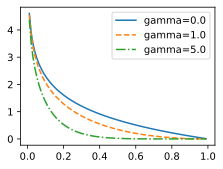

In [36]:
def focal_loss(gamma, x):
    """
    Focal Loss损失函数

    参数：
        gamma：Focal Loss的调节参数
        x：输入数据

    返回：
        Focal Loss损失
    """
    return -(1 - x) ** gamma * torch.log(x)

# 定义一些参数
x = torch.arange(0.01, 1, 0.01)
d2l.set_figsize()

# 绘制Focal Loss损失函数曲线
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();

**解答：**

&emsp;&emsp;能通过改进损失函数来改进，比如这里将预测偏移量用到的$L_1$范数损失替换为平滑$L_1$范数损失，将类别预测用到的交叉熵损失替换为焦点损失。

&emsp;&emsp;设置平滑$L_1$范数的参数$\sigma$为2；焦点损失的参数$\alpha$为0.25，$\gamma$为2进行
实验如下：

In [37]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [38]:
#类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)
#边框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

#连结多尺度的预测
def concat_preds(preds):
    """
    连结多尺度的预测结果

    参数：
        preds：多尺度的预测结果列表

    返回：
        连结后的预测结果
    """
    return torch.cat([flatten_pred(p) for p in preds], dim=1)
#高和宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

#基本网络块
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)


#完整的单发多框检测模型由五个模块组成
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

# 为每个块定义前向传播
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """
    定义每个块的前向传播

    参数：
        X：输入数据
        blk：块
        size：锚框的尺度
        ratio：锚框的长宽比
        cls_predictor：类别预测层
        bbox_predictor：边框预测层

    返回：
        块的输出、锚框、类别预测结果和边框预测结果
    """
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

#超参数
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

#完整模型
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句 `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # `getattr(self, 'blk_%d' % i)` 即访问 `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [39]:
# 读取数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

# 初始化模型参数并定义优化算法
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

# 评价函数
def cls_eval(cls_preds, cls_labels):
    """
    计算类别预测的准确率

    参数：
        cls_preds：类别预测结果
        cls_labels：类别标签

    返回：
        准确率
    """
    # 由于类别预测结果放在最后一维， `argmax` 需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    """
    计算边框预测的损失

    参数：
        bbox_preds：边框预测结果
        bbox_labels：边框标签
        bbox_masks：边框掩码

    返回：
        损失
    """
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

read 1000 training examples
read 100 validation examples


In [40]:
# 定义损失函数

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        Focal Loss损失函数

        参数：
            alpha：平衡因子
            gamma：聚焦因子
            reduction：损失的计算方式，可选'mean'或'sum'

        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        """
        前向传播计算Focal Loss损失

        参数：
            input：模型预测结果
            target：真实标签

        返回：
            Focal Loss损失
        """
        log_probs = F.log_softmax(input, dim=1)
        probs = torch.exp(log_probs)
        pt = probs.gather(1, target.view(-1, 1))
        focal_weights = (self.alpha * (1 - pt) ** self.gamma).view(-1)
        loss = F.nll_loss(log_probs, target, reduction='none')
        weighted_loss = focal_weights * loss

        if self.reduction == 'mean':
            return weighted_loss.mean()
        elif self.reduction == 'sum':
            return weighted_loss.sum()
        else:
            return weighted_loss

class SmoothL1Loss(nn.Module):
    def __init__(self, sigma=1,reduction='mean'):
        """
        Smooth L1 Loss损失函数

        参数：
            sigma：平滑因子
            reduction：损失的计算方式，可选'mean'或'sum'
        """
        super(SmoothL1Loss, self).__init__()
        self.sigma = sigma
        self.reduction = reduction

    def forward(self, input, target):
        """
        前向传播计算Smooth L1 Loss损失

        参数：
            input：模型预测结果
            target：真实标签

        返回：
            Smooth L1 Loss损失
        """
        diff = torch.abs(input - target)
        loss = torch.where(diff < 1/self.sigma**2, 0.5 * (self.sigma*diff) ** 2, diff - 0.5/self.sigma**2)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 定义Focal Loss和Smooth L1 Loss
cls_loss = FocalLoss(alpha=0.25, gamma=2.0, reduction='None')
bbox_loss =SmoothL1Loss(sigma= 2,reduction='None')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """
    计算总损失

    参数：
        cls_preds：类别预测结果
        cls_labels：类别标签
        bbox_preds：边框预测结果
        bbox_labels：边框标签
        bbox_masks：边框掩码

    返回：
        总损失
    """
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

class err 4.09e-03, bbox mae 3.17e-03
7631.8 examples/sec on cuda:0


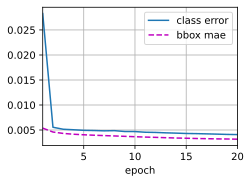

In [41]:
# 训练函数
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)

# 开始训练
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

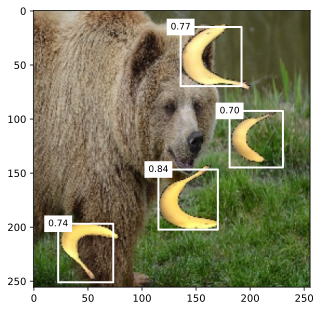

In [42]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

# 根据锚框及其预测偏移量得到预测边界框。然后，通过非极大值抑制来移除相似的预测边界框
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

# 筛选所有置信度不低于0.9的边界框，做为最终输出
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.7)

### 练习13.7.2

由于篇幅限制，我们在本节中省略了单发多框检测模型的一些实现细节。能否从以下几个方面进一步改进模型：

1. 当目标比图像小得多时，模型可以将输入图像调大；
2. 通常会存在大量的负锚框。为了使类别分布更加平衡，我们可以将负锚框的高和宽减半；
3. 在损失函数中，给类别损失和偏移损失设置不同比重的超参数；
4. 使用其他方法评估目标检测模型，例如单发多框检测论文 `Liu.Anguelov.Erhan.ea.2016`中的方法。

**解答：**

&emsp;&emsp;当然可以，接下来一起讨论一下四种方式。

1. 调整输入图像大小： 当目标比图像小得多时，将输入图像调大是一个不错的思路。这可以提高模型对小目标的检测性能。确保调整后的图像仍然保持一定的质量，以免失真影响模型性能。
2. 调整负锚框的高和宽： 缩小负锚框的高和宽是为了使类别分布更加平衡，这是个好注意点。减小部分负样本的框可以增加负样本的难易程度，帮助训练，这可以减轻模型在负样本上的训练压力，提高模型对正样本的关注度。确保减半的尺寸仍然足够覆盖负样本的特征。
3. 不同比重的损失函数： 在损失函数中设置不同的类别损失和偏移损失的比重是一种调整模型权衡的方式。可以通过调整这些超参数来优化模型在类别分类和位置偏移方面的表现。
4. 使用其他评估方法： 参考其他方法，如 `Liu.Anguelov.Erhan.ea.2016`论文中提到的`Hard negative mining`和`Data augmentation`等等

## 13.8 区域卷积神经网络（R-CNN）系列

### 练习13.8.1

我们能否将目标检测视为回归问题（例如预测边界框和类别的概率）？可以参考YOLO模型的设计。

**解答：**

&emsp;&emsp;目标检测可以被视为回归问题，其中边界框的坐标和目标的类别可以被预测为连续值。这类方法目前主要分为三个系列：YOLO系列、SSD系列和Anchor Free系列。

&emsp;&emsp;YOLO模型将目标检测问题直接视为一个回归问题。YOLO模型将图像划分为网格，并预测每个网格的边界框和类别的概率。对于每个边界框，YOLO模型通过回归预测其坐标和大小。此外，对于每个网格，模型还预测每个类别的置信度得分，表示该网格中是否包含该类别的目标。


### 练习13.8.2        
        
将单发多框检测与本节介绍的方法进行比较。他们的主要区别是什么？可以参考参考文献[195]中的图2。

**解答：**

[Zhao et al., 2019](https://arxiv.org/pdf/1807.05511.pdf&usg=ALkJrhhpApwNJOmg83O8p2Ua76PNh6tR8A)

![image.png](../../images/ob_detection_deeplearning.png)

&emsp;&emsp;它们的区别主要体现在检测方式、速度和准确性、训练方式三个方面。
- 检测方式：

    - SSD是一种单阶段（one-stage）目标检测方法，它通过将不同尺度和比例的预定义锚框（anchor boxes）应用于图像的不同位置，直接回归目标的边界框位置和类别信息。
    - RCNN系列是两阶段（two-stage）目标检测方法的代表，其中包括R-CNN、Fast R-CNN、Faster R-CNN和Mask R-CNN等。这些方法首先在图像中生成候选区域（region proposals），然后对这些候选区域进行分类和边界框回归。

- 速度和准确性：

    - SSD是一种高速目标检测方法，因为它是单阶段的，并且在单次前向传播中同时执行分类和边界框回归。这种设计使得SSD在处理速度上相对较快，适用于实时应用和对速度要求较高的场景。然而，相对于RCNN系列，SSD在目标检测的准确性上可能会稍逊一筹。
    - RCNN系列虽然相对较慢，但在准确性上通常优于SSD。它的两阶段设计允许更精细的特征提取和候选区域的筛选，从而提高了目标检测的准确性。尤其是Mask R-CNN在实例分割任务上表现出色。

- 训练方式：

    - SSD使用硬负样本挖掘（Hard Negative Mining）来平衡正负样本的数量，并使用多尺度特征图来检测不同尺度的目标。
    - RCNN系列的训练过程包括候选区域生成和区域分类/边界框回归两个阶段。它们通常使用区域建议网络（Region Proposal Network，RPN）来生成候选区域，并使用RoI池化（Region of Interest pooling）等技术来提取区域特征。

&emsp;&emsp;总的来说，SSD适用于需要快速处理速度的实时应用场景，而RCNN系列则更适合对准确性要求较高的任务。

## 13.9 语义分割和数据集

### 练习13.9.1

如何在自动驾驶和医疗图像诊断中应用语义分割？还能想到其他领域的应用吗？

**解答：**

&emsp;&emsp;语义分割在自动驾驶和医疗图像诊断中有着广泛的应用，以及其他领域也可以采用语义分割技术。

1. 自动驾驶：语义分割可以用于场景理解和障碍物检测。通过将道路、行人、车辆等不同类别分割出来，可以更好地理解驾驶场景，并帮助自动驾驶系统做出相应的决策和规划。例如，可以利用语义分割来区分车道线、交通信号灯、行人等，以实现智能的驾驶行为。

2. 医疗图像诊断：语义分割在医疗图像诊断中扮演着重要的角色。它可以用于分割病变区域，例如肿瘤、病变组织或器官，以帮助医生进行准确的诊断和治疗。通过将医学图像中的不同结构和组织分割出来，医生可以更好地分析和理解病变的位置、大小和形状，以制定有效的治疗计划。

除了自动驾驶和医疗图像诊断，语义分割还有许多其他领域的应用，包括但不限于：

3. 视频分析：语义分割可以用于视频中的对象跟踪、行为分析和场景理解。通过对视频帧进行语义分割，可以更好地理解视频中不同对象的运动和交互关系，为视频分析和智能监控提供支持。

4. 农业和环境监测：语义分割可以帮助农业领域和环境监测中的作物检测、土地利用分类、植被监测等任务。通过对遥感图像或无人机采集的图像进行语义分割，可以获得关于作物类型、土地利用情况和植被覆盖等信息，以支持精细化农业管理和环境保护。

5. 增强现实和虚拟现实：语义分割可以为增强现实和虚拟现实应用提供空间理解和交互性。通过对实时摄像头或虚拟场景中的图像进行语义分割，可以识别和分割出不同的物体、表面和环境元素，从而实现更逼真和交互性的增强现实和虚拟现实体验。

6. 安防： 在视频监控中应用语义分割，可以更精细地分析场景，识别异常行为或感知安全风险。


### 练习13.9.2

回想一下13.1节中对数据增强的描述。图像分类中使用的哪种图像增强方法是难以用于语义分割的？

**解答：**

&emsp;&emsp;在图像分类中，一种常见的图像增强方法是随机裁剪（Random Crop）。该方法通过在图像中随机选择一个区域并进行裁剪，以提高数据的多样性和模型的泛化能力。然而，在语义分割中，这种随机裁剪方法难以直接应用。在语义分割任务中，不仅需要对图像进行裁剪，还需要相应地对标签（分割掩码）进行裁剪，以确保标签与图像保持一致。然而，随机裁剪可能导致图像和标签不对齐，从而破坏了语义分割的准确性。因此，在语义分割中更倾向于使用一些能够保持像素级对应关系的增强方法，例如随机缩放、随机翻转和弹性变换等。这些方法能够确保输入图像和标签之间的一致性，有助于提升模型性能。

## 13.10 转置卷积

### 练习13.10.1

在13.10.3节中，卷积输入`X`和转置的卷积输出`Z`具有相同的形状。他们的数值也相同吗？为什么？

**解答：**

&emsp;&emsp;在卷积神经网络的上采样（转置卷积）操作中，卷积输入`X`和转置的卷积输出`Z`具有相同的形状，但它们的数值通常是不同的。

1. **形状相同：** 这是因为在转置卷积操作中，通常会使用填充（padding）和步幅（stride）来确保输出的形状与输入相同。这是为了保持空间维度的一致性，使得上采样后的特征图能够对应到原始输入图像的相应区域。

2. **数值不同：** 尽管形状相同，但转置卷积的数值通常是不同的。这是因为转置卷积使用了卷积核的转置（通常称为转置滤波器），它与普通卷积核的权重不同。在反卷积（转置卷积）中，我们需要对输入进行插值和填充，以便生成更细致的输出。这意味着转置卷积中的数值计算通常不会与原始输入完全匹配。

&emsp;&emsp;总体来说，形状相同是因为我们通过调整填充和步幅来确保输出大小与输入相同，但数值通常是不同的，因为转置卷积引入了插值和填充操作。

In [43]:
import torch
from torch import nn
from d2l import torch as d2l

In [44]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # 在输出特征图上根据卷积核进行反卷积操作
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [45]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Z = trans_conv(Y, K)
Z

tensor([[ 27.,  91.,  74.],
        [138., 400., 282.],
        [171., 429., 268.]])

In [46]:
X

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

### 练习13.10.2
        
1. 使用矩阵乘法来实现卷积是否有效率？为什么？

**解答：**

&emsp;&emsp;使用矩阵乘法来实现卷积并不是最有效的方式，因为卷积操作具有稀疏性和权值共享的特点，而矩阵乘法没有充分利用这些特性。

&emsp;&emsp;1. 稀疏性丧失： 卷积操作中的卷积核是局部连接的，即每个输出位置仅与输入的局部区域相连。这导致了输入和输出矩阵的稀疏性，因为它们大部分元素是零。但是，通过矩阵乘法，会引入大量的零元素，导致稀疏性丧失，使得计算效率降低。

&emsp;&emsp;2. 卷积操作还利用了权值共享的概念，即卷积核的权值在整个输入上是共享的。这意味着在计算卷积操作时，可以重复使用相同的权值，减少了计算量。然而，在矩阵乘法中，每个权值都需要在乘法过程中进行完整计算，没有利用权值共享的优势。

&emsp;&emsp;3. 不适用于大尺寸卷积核： 对于具有大尺寸卷积核的情况，使用矩阵乘法的计算复杂度会急剧增加，不太适用于实际应用。

## 13.11 全卷积网络

### 练习13.11.1

如果将转置卷积层改用Xavier随机初始化，结果有什么变化？

**解答：**

In [51]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [52]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))#1×1卷积
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))#转置卷积

In [53]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """
    创建一个双线性插值卷积核

    参数：
    in_channels：输入通道数
    out_channels：输出通道数
    kernel_size：卷积核大小

    返回：
    weight：双线性插值卷积核

    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

def loss(inputs, targets):
    """
    计算损失函数

    参数：
    inputs：输入数据
    targets：目标数据

    返回：
    损失值

    """

    loss = F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)
    return loss

loss 1.526, train acc 0.730, test acc 0.729
270.1 examples/sec on [device(type='cuda', index=0)]


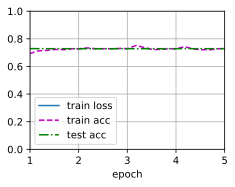

In [54]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)

# conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

nn.init.xavier_uniform_(conv_trans.weight)

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 练习13.11.2

调节超参数，能进一步提升模型的精度吗？

**解答：**

&emsp;&emsp;可以条件学习率以及权重衰减系数，不采用权重衰退的结果如下。

loss 1.491, train acc 0.727, test acc 0.728
256.9 examples/sec on [device(type='cuda', index=0)]


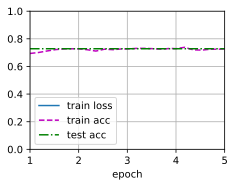

In [55]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))#1×1卷积
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))#转置卷积

pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*list(pretrained_net.children())[:-2])
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))#1×1卷积
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))#转置卷积

conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
#nn.init.xavier_uniform_(conv_trans.weight)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)


num_epochs, lr, wd, devices = 5, 0.001, 0, d2l.try_all_gpus()#不采用权重衰退
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 练习13.11.3

预测测试图像中所有像素的类别。

**解答：**

&emsp;&emsp;接下来利用模型进行预测

In [56]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [57]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

In [58]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


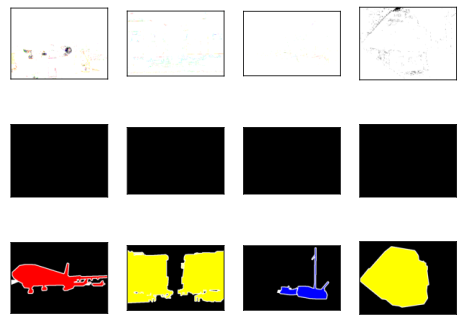

In [59]:
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    #X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    X = test_images[i]#预测所有像素的类别

    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
                 test_labels[i].permute(1,2,0)]
A = imgs[::3] + imgs[1::3] + imgs[2::3]
d2l.show_images([i.to(torch.float32) for i in A], 3, n, scale=2);

### 练习13.11.4

最初的全卷积网络的论文中还使用了某些卷积神经网络中间层的输出。试着实现这个想法。

**解答：**

&emsp;&emsp;我们可以将卷积神经网络的中间层输出与转置卷积层的输出进行融合，下面采用逐元素相加的方式进行融合。

In [60]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        # Encoder部分
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # ...
        
        # Decoder部分，使用转置卷积层进行上采样
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv3 = nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        
        # 跳跃连接部分
        self.skip_conv1 = nn.Conv2d(64, num_classes, kernel_size=1)
        self.skip_conv2 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.skip_conv3 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder部分
        x1 = torch.relu(self.encoder_conv1(x))
        x2 = torch.relu(self.encoder_conv2(x1))
        x3 = torch.relu(self.encoder_conv3(x2))
        # Decoder部分，使用转置卷积层进行上采样
        x = torch.relu(self.decoder_conv1(x3))
        skip1 = self.skip_conv1(x1)
        skip1 = self.crop_and_concat(skip1, x)  # 调整大小并与x相加
        x = torch.relu(self.decoder_conv2(x))
        skip2 = self.skip_conv2(x2)
        skip2 = self.crop_and_concat(skip2, x)  # 调整大小并与x相加
        x = self.decoder_conv3(x)
        skip3 = self.skip_conv3(x3)
        skip3 = self.crop_and_concat(skip3, x)  # 调整大小并与x相加
        return x

    def crop_and_concat(self, x1, x2):
        # 调整x1的大小，使其与x2的大小一致
        _, _, H, W = x2.size()
        x1 = torch.nn.functional.interpolate(x1, size=(H, W), mode='bilinear', align_corners=True)
        return torch.cat((x1, x2), dim=1)  # 在通道维度上拼接

# 创建FCN实例并指定类别数
num_classes = 21  # 示例中使用21类，可以根据任务需求进行修改
model = FCN(num_classes)

# 使用模型进行前向传播
input_data = torch.randn(1, 3, 256, 256)  # 假设输入图像尺寸为256x256
output = model(input_data)
output.shape

torch.Size([1, 21, 2048, 2048])

## 13.12 风格迁移

### 练习13.12.1

选择不同的内容和风格层，输出有什么变化？

**解答：**

&emsp;&emsp;选取不同的网络层数为`style_layers, content_layers = [0, 4, 9, 18, 28], [26]`。

&emsp;&emsp;一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。我们选取的风格层更靠近输入层，内容层更靠近输出层，由实验的结果可以看出，图像的细节更多，图像中的内容更加清晰了。

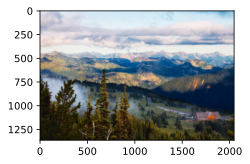

In [61]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

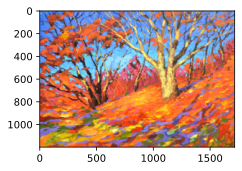

In [62]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [63]:
## 预处理和后处理

# RGB均值和标准差
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 风格层和内容层的索引
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

# 权重参数
content_weight, style_weight, tv_weight = 1, 1e3, 10

def preprocess(img, image_shape):
    """
    预处理函数：将图像进行缩放、转换为张量，并进行归一化处理

    参数：
    img：输入图像
    image_shape：目标图像大小

    返回：
    预处理后的图像张量

    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    """
    后处理函数：将张量转换为图像，并进行反归一化处理

    参数：
    img：输入张量

    返回：
    后处理后的图像

    """
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## 特征提取

def extract_features(X, content_layers, style_layers):
    """
    提取特征函数：从网络中提取内容特征和样式特征

    参数：
    X：输入图像张量
    content_layers：内容层索引
    style_layers：样式层索引

    返回：
    contents：内容特征列表
    styles：样式特征列表

    """
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    """
    获取内容特征函数：将内容图像进行预处理，并提取内容特征

    参数：
    image_shape：目标图像大小
    device：计算设备

    返回：
    content_X：预处理后的内容图像张量
    contents_Y：内容特征列表

    """
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    """
    获取样式特征函数：将样式图像进行预处理，并提取样式特征

    参数：
    image_shape：目标图像大小
    device：计算设备

    返回：
    style_X：预处理后的样式图像张量
    styles_Y：样式特征列表

    """
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

##损失函数

def content_loss(Y_hat, Y):
    """
    内容损失函数：计算内容损失

    参数：
    Y_hat：合成图像的内容特征
    Y：目标内容特征

    返回：
    内容损失值

    """
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

def gram(X):
    """
    Gram矩阵函数：计算输入特征的Gram矩阵

    参数：
    X：输入特征

    返回：
    Gram矩阵

    """
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())


def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    """
    计算损失函数：计算内容损失、样式损失和总变差损失

    参数：
    X：合成图像
    contents_Y_hat：合成图像的内容特征列表
    styles_Y_hat：合成图像的样式特征列表
    contents_Y：目标内容特征列表
    styles_Y_gram：目标样式特征的Gram矩阵列表

    返回：
    contents_l：内容损失列表
    styles_l：样式损失列表
    tv_l：总变差损失
    l：总损失

    """
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 初始化合成图像
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight
    
def get_inits(X, device, lr, styles_Y):
    """
    获取初始化参数函数：初始化合成图像、样式特征的Gram矩阵和优化器

    参数：
    X：内容图像
    device：计算设备
    lr：学习率
    styles_Y：样式特征列表

    返回：
    gen_img：初始化的合成图像
    styles_Y_gram：样式特征的Gram矩阵列表
    trainer：优化器

    """
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    """
    训练函数：训练合成图像

    参数：
    X：内容图像
    contents_Y：目标内容特征列表
    styles_Y：目标样式特征列表
    device：计算设备
    lr：学习率
    num_epochs：训练轮数
    lr_decay_epoch：学习率衰减轮数

    返回：
    X：训练后的合成图像

    """
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

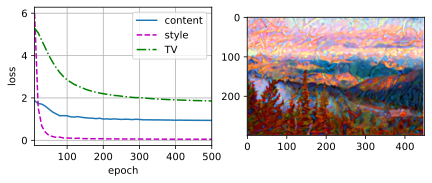

In [64]:
# 使用预训练的VGG19模型作为基础网络
pretrained_net = torchvision.models.vgg19(pretrained=True)

# 设置风格层和内容层的索引
# 在VGG19中，索引为0、4、9、18、28的层被认为是风格层
# 索引为26的层被认为是内容层
style_layers, content_layers = [0, 4, 9, 18, 28], [26]

# 创建一个新的网络，只包含需要的风格层和内容层
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

# 设置内容损失、风格损失和总变差损失的权重
content_weight, style_weight, tv_weight = 1, 1e3, 10

# 设置设备和图像尺寸
device, image_shape = d2l.try_gpu(), (300, 450)

# 将网络迁移到指定的设备上
net = net.to(device)

# 获取内容图像和风格图像的特征表示
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)

# 进行训练，返回生成的图像
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

### 练习13.12.2

调整损失函数中的权重超参数。输出是否保留更多内容或减少更多噪点？

**解答：**

&emsp; &emsp;风格转移的损失函数是内容损失、风格损失和总变化损失的加权和。我们将原先的超参数[1, 1e3, 10]更改为[1e3, 1, 10]。发现当我们减少内容损失的权重，增加风格损失的权重时，输出保留了更多的噪点。

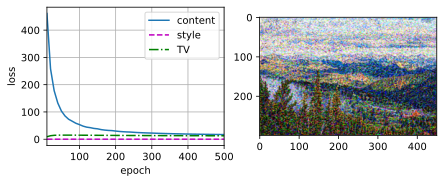

In [65]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

content_weight, style_weight, tv_weight = 1e3, 1, 10

device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

### 练习13.12.3

替换实验中的内容图像和风格图像，能创作出更有趣的合成图像吗？

**解答：**

&emsp; &emsp;这一部分我们替换了两个风格图像，得到了不错的实验效果

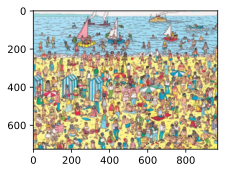

In [66]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../img/where-wally-walker-books.jpg')
d2l.plt.imshow(content_img);

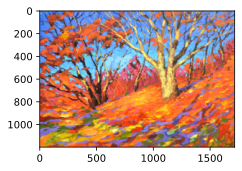

In [67]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

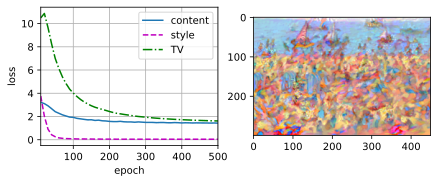

In [68]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

content_weight, style_weight, tv_weight = 1, 1e3, 10

device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

### 练习13.12.4

我们可以对文本使用风格迁移吗？提示:可以参阅调查报告[68]。

**解答：**

&emsp;&emsp;可以。文本风格迁移是一种将给定文本的风格从一个样式（例如正式、非正式、形式、非形式等）转移到另一个样式的任务，旨在保留文本内容的基础上通过编辑或生成的方式更改文本的特定风格或属性（如情感、时态和性别等）。它类似于图像风格迁移，但在文本领域中操作文本序列而不是图像像素。

## 13.13 实战 Kaggle 比赛：图像分类 (CIFAR-10) 

### 练习13.13.1

在这场Kaggle竞赛中使用完整的CIFAR-10数据集。将超参数设为`batch_size = 128`，`num_epochs = 100`，`lr = 0.1`，`lr_period = 50`，`lr_decay = 0.1`。看看在这场比赛中能达到什么准确度和排名。能进一步改进吗？

**解答：**

&emsp;&emsp;`demo`=True设置的是仅使用示例数据进行训练的，在该参数设置下模型性能极差，大家可以试着设置`demo = False`，使用完整数据对模型进行训练，但是这样可能计算量也会更大，这里面可以权衡一下。在这一部分，我先使用`demo`=True进行设置

&emsp;&emsp;一定要注意，如果使用完整的CIFAR-10数据集，要去kaggle进行下载

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
# 如果你使用完整的Kaggle竞赛的数据集，设置`demo`为 False
# 如果你使用tiny的数据集，设置`demo`为 True
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

    
labels = d2l.read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练示例 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练示例 : 50000
# 类别 : 10


In [3]:
def reorg_cifar10_data(data_dir, valid_ratio):
    """
    重新组织CIFAR-10数据集的函数。
    
    参数:
        - data_dir : str : 数据文件夹的路径
        - valid_ratio : float : 验证集所占比例
        
    返回:
        无返回值
    """
    # 读取标签数据
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    
    # 重新组织训练集和验证集
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    
    # 重新组织测试集
    d2l.reorg_test(data_dir)

valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [4]:
def get_net():
    """
    获取ResNet18模型的函数。

    返回:
        - net : torch.nn.Module : ResNet18模型
    """
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    """
    训练函数，用于训练模型。

    参数:
        - net : torch.nn.Module : 需要训练的模型
        - train_iter : torch.utils.data.DataLoader : 训练集数据迭代器
        - valid_iter : torch.utils.data.DataLoader : 验证集数据迭代器
        - num_epochs : int : 训练的轮数
        - lr : float : 学习率
        - wd : float : 权重衰减
        - devices : list : 使用的设备列表
        - lr_period : int : 学习率衰减周期
        - lr_decay : float : 学习率衰减因子

    返回:
        无返回值
    """
    # 定义优化器和学习率调度器
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)

    # 获取训练集的批次数量和计时器
    num_batches, timer = len(train_iter), d2l.Timer()

    # 定义动画绘制器
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)

    # 将模型传送到设备上
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # 开始训练
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)  # 用于累加训练损失和准确率的指标
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            # 训练一个批次并返回损失和准确率
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()

            # 每训练完成1/5的批次或者最后一个批次时，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))

        # 如果提供了验证集迭代器，则评估模型在验证集上的准确率，并更新动画
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))

        # 更新学习率
        scheduler.step()

    # 输出训练结果
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [5]:
# 定义训练数据的转换操作
transform_train = torchvision.transforms.Compose([
    # 将图像的高度和宽度放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像
    # 生成一个面积为原始图像面积0.64到1倍的小正方形
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    # 随机水平翻转图像
    torchvision.transforms.RandomHorizontalFlip(),
    # 将图像转换为张量
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

# 定义测试数据的转换操作
transform_test = torchvision.transforms.Compose([
    # 将图像转换为张量
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [6]:
# 定义训练数据集和训练验证数据集
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# 定义验证数据集和测试数据集
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [7]:
# 定义批次大小
batch_size = 32 if demo else 128

# 创建训练迭代器和训练验证迭代器
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

# 创建验证迭代器
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

# 创建测试迭代器
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

train loss nan, train acc 0.100, valid acc 0.100
4159.5 examples/sec on [device(type='cuda', index=0)]


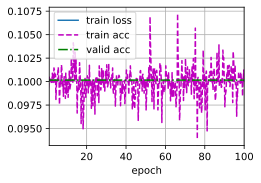

In [8]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 100, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss nan, train acc 0.100
4170.8 examples/sec on [device(type='cuda', index=0)]


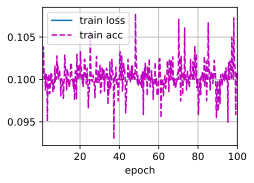

In [9]:
# 创建神经网络模型
net, preds = get_net(), []

# 训练神经网络模型
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# 对测试数据集进行预测
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

# 对预测结果进行排序
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))

# 创建DataFrame对象保存结果
df = pd.DataFrame({'id': sorted_ids, 'label': preds})

# 将标签转换为对应的类别
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])

# 将结果保存为CSV文件
df.to_csv('submission.csv', index=False)

&emsp;&emsp;根据结果分析，无论是在训练集还是验证集上，准确率都相对较低。这表明在当前的数据集和参数设置下，模型实际上并未得到有效的优化，提交到kaggle上得分也只有0.1。如果想得到更好的效果，可能需要对数据增广进行修改和调整参数的设置。

### 练习13.13.2

不使用图像增广时，能获得怎样的准确度？

**解答：**

&emsp;&emsp;在深度学习中，使用图像增强技术通常有助于提高模型的泛化能力，尤其是当训练数据有限时。图像增强通过在训练过程中对输入图像进行变换，生成多样性的训练样本，从而使模型更能适应不同的输入变化。

&emsp;&emsp;在当前实验中未使用图像增强的情况下，模型表现尚可。从分析来看，这可能是因为不使用图像增强使问题相对简化，尽管模型的泛化性能可能较差，但在有限的数据集中仍能呈现良好的结果。最终，在训练集上达到100%的准确率，而在测试集上为83.19%，虽然泛化性有一定差距，但对于简单问题而言，这样的参数设置仍然适用。如果考虑到更复杂的情况，可能需要重新调整参数，并考虑引入图像增强技术。

In [10]:
# 如果你使用完整的Kaggle竞赛的数据集，设置`demo`为 False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'
    
labels = d2l.read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练示例 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练示例 : 50000
# 类别 : 10


In [11]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]#不使用图像增广

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

train loss 0.000, train acc 1.000, valid acc 0.841
4411.9 examples/sec on [device(type='cuda', index=0)]


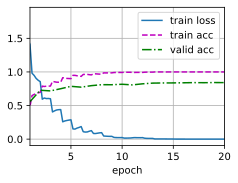

In [12]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.000, train acc 1.000
4442.5 examples/sec on [device(type='cuda', index=0)]


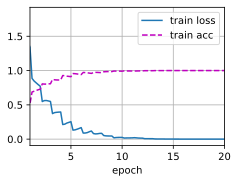

In [13]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

&emsp;&emsp;Kaggle提交后获得了83.19的得分，这一结果与预期有些出入，尤其是在未使用图像增强的情况下表现更好。这可能与参数设置和图像增强策略有关。为了取得更好的效果，可能需要重新调整超参数。

## 13.14 实战Kaggle比赛：狗的品种识别（ImageNet Dogs）

### 练习13.14.1

试试使用完整Kaggle比赛数据集，增加`batch_size`（批量大小）和`num_epochs`（迭代轮数），或者设计其它超参数为`lr = 0.01`，`lr_period = 10`，和`lr_decay = 0.1`时，能取得什么结果？

**解答：**

&emsp;&emsp;在这一部分也是使用lr = 0.01，lr_period = 10，和lr_decay = 0.1参数进行设置，使用完整的Kaggle比赛数据集，实验具体如下：

In [14]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [15]:
# 如果你使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = False
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [16]:
def reorg_dog_data(data_dir, valid_ratio):
    """
    重新组织狗的数据集，将数据分为训练集、验证集和测试集

    Parameters:
        data_dir (str): 数据集所在的目录
        valid_ratio (float): 验证集所占比例

    Returns:
        None
    """
    # 读取标签信息
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    
    # 重新组织训练集和验证集
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    
    # 重新组织测试集
    d2l.reorg_test(data_dir)


# 设置批量大小
batch_size = 32 if demo else 128

# 设置验证集所占比例
valid_ratio = 0.1

# 调用函数重新组织数据集
reorg_dog_data(data_dir, valid_ratio)

In [17]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224 x 224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

In [18]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [19]:
# 创建训练数据集和训练+验证数据集
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# 创建验证数据集和测试数据集
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

# 创建训练数据集迭代器和训练+验证数据集迭代器
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

# 创建验证数据集迭代器
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

# 创建测试数据集迭代器
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [20]:
def get_net(devices):
    """
    构建模型网络

    Parameters:
        devices (list): 设备列表，用于指定模型计算的设备

    Returns:
        nn.Module: 构建好的模型网络
    """
    # 创建一个空的序列模型
    finetune_net = nn.Sequential()
    
    # 加载预训练的ResNet34模型作为特征提取器
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    
    # 冻结特征提取器的参数，只训练新添加的输出网络部分
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    
    return finetune_net

In [21]:
# 定义损失函数
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    # 初始化损失总和和样本数量
    l_sum, n = 0.0, 0
    
    # 遍历数据迭代器，计算损失
    for features, labels in data_iter:
        # 将数据和标签移动到指定设备上
        features, labels = features.to(devices[0]), labels.to(devices[0])
        
        # 使用模型进行前向传播，得到预测输出
        outputs = net(features)
        
        # 计算损失
        l = loss(outputs, labels)
        
        # 累加损失总和
        l_sum += l.sum()
        
        # 累加样本数量
        n += labels.numel()
    
    # 返回平均损失
    return (l_sum / n).to('cpu')

In [22]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    """
    模型训练函数

    Parameters:
        net (nn.Module): 模型网络
        train_iter (DataLoader): 训练数据集迭代器
        valid_iter (DataLoader): 验证数据集迭代器
        num_epochs (int): 训练的轮数
        lr (float): 学习率
        wd (float): 权重衰减
        devices (list): 设备列表，用于指定模型计算的设备
        lr_period (int): 学习率更新周期
        lr_decay (float): 学习率衰减率

    Returns:
        None
    """
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    # 使用随机梯度下降优化器进行模型训练
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    
    # 使用学习率调度器进行学习率调整
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    
    # 创建动画器用于可视化训练过程
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        
        # 遍历训练数据集迭代器，进行模型训练
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            
            # 将输入数据和标签移动到设备上
            features, labels = features.to(devices[0]), labels.to(devices[0])
            
            # 清除优化器的梯度
            trainer.zero_grad()
            
            # 前向传播计算模型输出
            output = net(features)
            
            # 计算损失函数
            l = loss(output, labels).sum()
            
            # 反向传播计算梯度
            l.backward()
            
            # 更新模型参数
            trainer.step()
            
            # 统计训练损失和样本数量
            metric.add(l, labels.shape[0])
            timer.stop()
            
            # 每完成训练数据集的五分之一或者最后一个批次时，可视化训练损失
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        
        # 如果有验证数据集，则计算并可视化验证损失
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach()))
        
        # 更新学习率
        scheduler.step()
    
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    
    # 打印训练结果
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 87475543698202394624.000, valid loss 98321241743556608.000
1850.7 examples/sec on [device(type='cuda', index=0)]


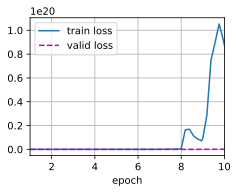

In [23]:
#调整超参数lr = 0.01，lr_period = 10，和lr_decay = 0.1
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 0.01, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 249835754849525682929664.000
1830.4 examples/sec on [device(type='cuda', index=0)]


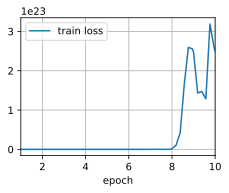

In [24]:
# 创建模型网络
net = get_net(devices)

# 进行模型训练
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 初始化预测结果列表
preds = []

# 遍历测试数据集迭代器，进行预测
for data, label in test_iter:
    # 将数据移动到指定设备上，并通过模型进行预测
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    
    # 将预测结果转换为numpy数组，并添加到预测结果列表中
    preds.extend(output.cpu().detach().numpy())

# 获取测试数据集中样本的ID，并按顺序排序
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))

# 创建并打开submission.csv文件，写入标题行
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    
    # 遍历测试样本的ID和预测结果，并写入submission.csv文件
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

&emsp;&emsp;提交到Kaggle上之后得分为13.49969，结果不是很好，从训练的结果也可以看出来，该次训练并没有得到很好的优化，可能需要重新调整超参数或者使用更好的预训练的网络模型。

### 练习13.14.2

如果使用更深的预训练模型，会得到更好的结果吗？如何调整超参数？能进一步改善结果吗？

**解答：**

&emsp;&emsp;在这个实验中，我们转而采用了ResNet50网络模型作为预训练模型，并增加了训练的轮次，以观察训练结果。

&emsp;&emsp;从实验结果来看，使用更深的ResNet50网络模型能够获得更好的效果。训练损失曲线呈逐渐下降的趋势，相较于使用ResNet18，我们得到了更为优异的结果和更平滑的曲线。

In [25]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet50(pretrained=True)#使用resnet50
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

train loss 0.799, valid loss 0.700
1189.2 examples/sec on [device(type='cuda', index=0)]


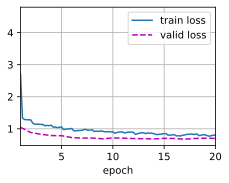

In [26]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.795
1193.0 examples/sec on [device(type='cuda', index=0)]


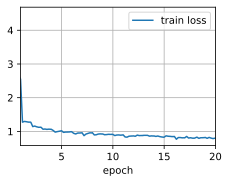

In [27]:
# 创建模型网络
net = get_net(devices)

# 进行模型训练
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 初始化预测结果列表
preds = []

# 遍历测试数据集迭代器，进行预测
for data, label in test_iter:
    # 将数据移动到指定设备上，并通过模型进行预测
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    
    # 将预测结果转换为numpy数组，并添加到预测结果列表中
    preds.extend(output.cpu().detach().numpy())

# 获取测试数据集中样本的ID，并按顺序排序
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))

# 创建并打开submission.csv文件，写入标题行
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    
    # 遍历测试样本的ID和预测结果，并写入submission.csv文件
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')

&emsp;&emsp;使用更深的ResNet50模型进行训练后，提交的得分为1.61759，取得了更为优秀的结果。观察训练过程，可以看到训练和验证损失逐渐下降，表明模型得到了持续优化。这验证了使用更深的网络结构能够取得更好效果的观点。